In [1]:
import os
import sys
import argparse
import pickle
import datetime as dt
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from sklearn.metrics import mean_squared_error

root_dir = '/srv/scratch/z5370003/projects/DeepGR4J-Extremes'
sys.path.append(root_dir)

from model.tf.ml import ConvNet, LSTM, get_mixed_model
from model.tf.hydro import ProductionStorage
from data.tf.camels_dataset import CamelsDataset, HybridDataset
from utils.evaluation import nse, normalize


# Window size
cdf_window_size = 7
flow_window_size = 7

# CDF TS Model Parameters
cdf_ts_model_name = 'lstm'

cdf_lstm_config = {
    'window_size': cdf_window_size,
    'input_dim': 6,
    'hidden_dim': 32,
    'output_dim': 8,
    'lstm_dim': 64,
    'n_layers': 4,
    'dropout': 0.2
}

cdf_cnn_config = {
    'window_size': cdf_window_size,
    'n_features': 6,
    'n_channels': 1,
    'output_dim': 8,
    'n_filters': [16, 16, 8],
    'dropout': 0.2
}

# CDF Static model parameters
cdf_static_config = {
    'input_dim': 7,
    'hidden_dim': 64,
    'output_dim': 8
}

# CDF Combined model parameters
cdf_combined_hidden_dim = 64
cdf_target_vars = ['flow_cdf']
cdf_output_dim = len(cdf_target_vars)

# Quantile NN model
flow_input_dim = 9
flow_hidden_dim = 32
flow_lstm_dim = 64
flow_n_layers = 4
flow_dropout = 0.2
flow_quantiles = [0.05, 0.5, 0.95]
flow_target_vars = ['streamflow_mmd']



# Directories
camels_data_dir = '../../data/camels/aus'
gr4j_results_dir = '../results/gr4j'
cdf_results_dir = '../results/flow_cdf'
deepgr4j_results_dir = '../results/qdeepgr4j_lstm/aus'
gr4j_results_path = f'{gr4j_results_dir}/result.csv'
results_dir = '../results/deepgr4j_extremes'


2024-10-01 19:00:25.298681: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-01 19:00:25.441897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 19:00:25.458861: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-01 19:00:25.464005: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-01 19:00:25.476390: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def generate_cdf_preds(model, dl, results_dir='../results/predictions'):
    
    preds = []
    true = []
    
    for step, batch in enumerate(dl):
        out = model([batch['timeseries'], batch['static']],
                     training=False) 
        preds.append(out)
        true.append(batch['target'])
    
    preds = tf.concat(preds, axis=0)
    true = tf.concat(true, axis=0)

    # Convert to numpy array
    preds = camels_ds.target_scaler.inverse_transform(preds.numpy())
    true = camels_ds.target_scaler.inverse_transform(true.numpy())

    # Plot results
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(preds[:, -1], label='pred')
    ax.plot(true[:, -1], label='true')
    plt.legend()
    fig.savefig(f'{results_dir}/cdf_preds.png', bbox_inches='tight')
    
    # Calculate scores
    mse_error = mean_squared_error(true[:, -1], preds[:, -1])
    
    return mse_error, preds



def generate_flow_preds(model, dl, results_dir='../results/predictions'):
    preds = []
    true = []

    for step, batch in enumerate(dl):
        out = model(batch['timeseries'],
                    training=False) 
        preds.append(out)
        true.append(batch['target'])
    
    preds = tf.concat(preds, axis=0)
    true = tf.concat(true, axis=0)

    # Convert to numpy array
    preds = hybrid_ds.target_scaler.inverse_transform(preds.numpy())
    true = hybrid_ds.target_scaler.inverse_transform(true.numpy())

    # Clip negative values
    preds = np.clip(preds, 0, None)

    # Plot results
    median_index = int(preds.shape[-1]//2)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(preds[:, median_index], label='pred', c='red')
    ax.plot(true[:, -1], label='true', c='black')
    ax.fill_between(range(len(preds)), preds[:, 0], preds[:, -1], alpha=0.5, color='green')
    plt.legend()
    fig.savefig(f'{results_dir}/flow_preds.png', bbox_inches='tight')
    
    # Calculate scores
    mse_score = mean_squared_error(true[:, -1], preds[:, median_index])
    nse_score = nse(true[:, -1], preds[:, median_index])
    nnse_score = normalize(nse_score)
    
    return mse_score, nse_score, nnse_score, preds, true


def select_by_quantiles(values_array, quantiles):
    indices = np.ones_like(quantiles)
    if values_array.shape[-1] == 3:
        indices[quantiles > 0.95] = 2
        indices[(quantiles <= 0.95) & (quantiles > 0.05)] = 1
        indices[quantiles <= 0.05] = 0
        indices = indices.astype(int).flatten()
    elif values_array.shape[-1] == 5:
        indices[(quantiles > 0.75)] = 4
        indices[(quantiles <= 0.75) & (quantiles > 0.50)] = 3
        indices[(quantiles <= 0.50) & (quantiles > 0.25)] = 2
        indices[(quantiles <= 0.25) & (quantiles > 0.05)] = 1
        indices[(quantiles <= 0.05)] = 0
    indices = indices.astype(int).flatten()
    selected_values = values_array[np.arange(len(indices)), indices]
    return selected_values


Running CDF model for NT - 53


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ timeseries          │ (None, 7, 6)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 8)         │     24,616 │ timeseries[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static (InputLayer) │ (None, 7)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 8)         │          0 │ lstm_9[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 8)         │      5,192 │ static[0][0]      │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 16)        │          0 │ activation_6[0][… │
│ (Concatenate)       │                   │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 64)        │      1,088 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 64)        │      4,160 │ dense_39[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 1)         │         65 │ dense_40[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 35,121 (137.19 KB)

 Trainable params: 35,121 (137.19 KB)

 Non-trainable params: 0 (0.00 B)

Running predictions for G9070142
Preparing CDF data
Skipping fit call on scalers
Generating CDF predictions
Preparing flow data
Production store X1: 661.29248046875


Model: "lstm_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_layer (LSTM)               │ ((5, 7, 64), (5, 64),  │        18,944 │
│                                 │ (5, 64))               │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (5, 192)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (5, 32)                │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_out (Dense)               │ (5, 3)                 │            99 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (5, 192)               │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,219 (98.51 KB)

 Trainable params: 25,219 (98.51 KB)

 Non-trainable params: 0 (0.00 B)

Skipping fit call on scalers
Generating flow predictions

MSE: 1.5378, NSE: 0.6152, NNSE: 0.7221
(12094,) (12090,)


IndexError: index 2417 is out of bounds for axis 0 with size 2417

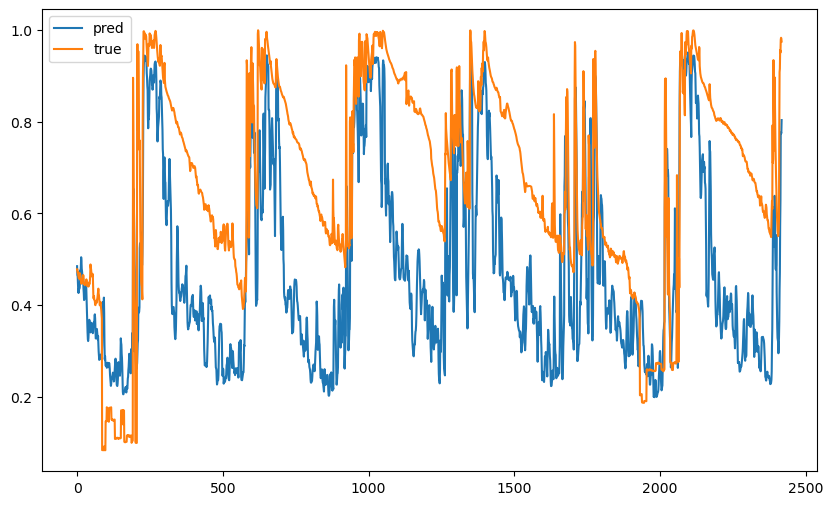

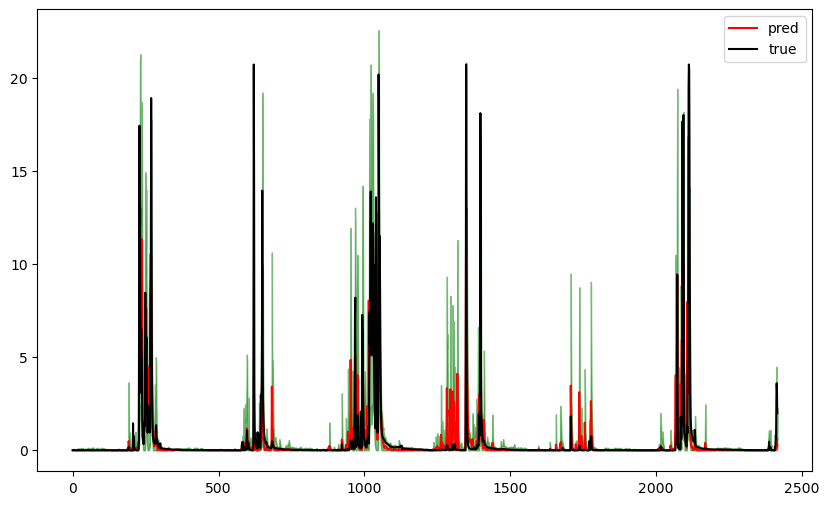

In [21]:
# CDF Dataset
camels_ds = CamelsDataset(data_dir=camels_data_dir, 
                        target_vars=cdf_target_vars,
                        window_size=cdf_window_size)

# zone_list = camels_ds.get_zones()

flow_ts_vars = ['precipitation_AWAP', 'et_morton_actual_SILO',
       'tmax_awap', 'tmin_awap', 'vprp_awap']

# results_all = []

# for (state_outlet, map_zone) in zone_list:
state_outlet = 'NT'
map_zone = 53
print(f'Running CDF model for {state_outlet} - {map_zone}')

# CDF model and scaler path
cdf_model_path = f'{cdf_results_dir}/{state_outlet}_{map_zone}/model.keras'
cdf_data_scaler_path = f'{cdf_results_dir}/{state_outlet}_{map_zone}/scalers.pkl'
camels_ds.load_scalers(cdf_data_scaler_path)

# Load CDF model for the zone
cdf_model = get_mixed_model(cdf_ts_model_name, cdf_lstm_config, cdf_static_config, cdf_combined_hidden_dim, cdf_output_dim)
cdf_model.load_weights(cdf_model_path)
cdf_model.summary()

# Filter stations for the zone
# station_list = camels_ds.get_station_list(state_outlet=state_outlet, map_zone=map_zone)

station_id = 'G9070142'

print(f'Running predictions for {station_id}')
flow_data_scaler_path = f'{deepgr4j_results_dir}/model/{station_id}/scalers.pkl'
flow_model_path = f'{deepgr4j_results_dir}/model/{station_id}/flow_model.weights.h5'
station_results_dir = f'{results_dir}/{station_id}'
os.makedirs(station_results_dir, exist_ok=True)

# Prepare flow CDF data
print('Preparing CDF data')
camels_ds.prepare_data(station_list=[station_id], year_cols=True)
cdf_train_ds, cdf_test_ds = camels_ds.get_datasets()
print('Generating CDF predictions')
_, cdf_preds = generate_cdf_preds(cdf_model, cdf_test_ds.batch(256), results_dir=station_results_dir)


# Quantile NN model
print('Preparing flow data')
prod = ProductionStorage()

hybrid_ds = HybridDataset(data_dir=camels_data_dir,
                          gr4j_logfile=gr4j_results_path,
                          prod=prod,
                          window_size=flow_window_size,
                          target_vars=flow_target_vars,
                          ts_vars=flow_ts_vars)

print(f'Production store X1: {hybrid_ds.prod.get_x1()}')

flow_model = LSTM(window_size=flow_window_size,
                  input_dim=flow_input_dim,
                  hidden_dim=flow_hidden_dim,
                  lstm_dim=flow_lstm_dim,
                  n_layers=flow_n_layers,
                  output_dim=len(flow_quantiles),
                  dropout=flow_dropout)

# Load flow model weights
flow_model(tf.random.uniform(shape=(5, flow_window_size, flow_input_dim)))
flow_model.summary()
flow_model.load_weights(flow_model_path)

try:
    hybrid_ds.load_scalers(flow_data_scaler_path)
    hybrid_ds.prepare_data(station_list=[station_id], year_cols=False)
except Exception as e:
    raise(e)
hybrid_train_ds, hybrid_test_ds = hybrid_ds.get_datasets()


# Generate flow predictions
print('Generating flow predictions')
res = generate_flow_preds(flow_model, hybrid_test_ds.batch(256), results_dir=station_results_dir)
mse_score, nse_score, nnse_score, qpreds, true = res
print(f'\nMSE: {mse_score:.4f}, NSE: {nse_score:.4f}, NNSE: {nnse_score:.4f}')


# Corrected preds using flow CDF
print(camels_ds._ts.shape, hybrid_ds._ts.shape)
flowpreds = select_by_quantiles(qpreds, cdf_preds)
mse_score_corrected = mean_squared_error(true.flatten(), flowpreds)
nse_score_corrected = nse(true.flatten(), flowpreds)
nnse_score_corrected = normalize(nse(true.flatten(), flowpreds))
nse_score_corrected, nnse_score_corrected


In [6]:
camels_ds.station_list

['G9070142']

In [7]:
hybrid_ds.station_list

['G9070142']

In [18]:
camels_ds.ts_data.shape

(12094, 8)

In [19]:
hybrid_ds.ts_data.shape

(12090, 7)

In [17]:
[t for t in camels_ds._ts if t not in hybrid_ds._ts]

[numpy.datetime64('1996-11-24T00:00:00.000000000'),
 numpy.datetime64('1999-09-20T00:00:00.000000000'),
 numpy.datetime64('2001-11-21T00:00:00.000000000'),
 numpy.datetime64('2013-11-02T00:00:00.000000000')]

In [23]:
camels_ds = CamelsDataset(data_dir=camels_data_dir, 
                        target_vars=cdf_target_vars,
                        ts_vars=flow_ts_vars,
                        window_size=cdf_window_size)


In [24]:
camels_ds.prepare_data(station_list=[station_id], year_cols=True)

Fitting scalers


In [25]:
camels_ds.ts_data.shape

(12090, 9)